## OCR CNN


**Config environment**

In [1]:
# GOOGLE COLAB
GOOGLE_COLAB = True # Are you using Google Colab ?
COLAB_WORKING_PATH = "/content/drive/My Drive/Colab/Botanist" # Path to folder in Google Drive

# PATHS
DATASET_PATH = "/content/drive/My Drive/Colab/Botanist/data_ocr_cnn"

In [2]:
# Mount on Google Drive
if GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


**Imports**

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

**CNN**

Found 96 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.7495 - accuracy: 0.5104 - val_loss: 0.6843 - val_accuracy: 0.7083
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.6235 - accuracy: 0.6979 - val_loss: 0.5706 - val_accuracy: 0.7083
Epoch 3/50
32/32 [==============================] - 1s 16ms/step - loss: 0.4140 - accuracy: 0.8333 - val_loss: 0.7283 - val_accuracy: 0.5833
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.2372 - accuracy: 0.9167 - val_loss: 0.6845 - val_accuracy: 0.7500
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1598 - accuracy: 0.9583 - val_loss: 0.6450 - val_accuracy: 0.7500
Epoch 6/50
32/32 [==============================] - 0s 13ms/step - loss: 0.1250 - accuracy: 0.9583 - val_loss: 1.0446 - val_accuracy: 0.6667
Epoch 7/50
32/32 [==============================] - 1s 16ms/step - loss: 0

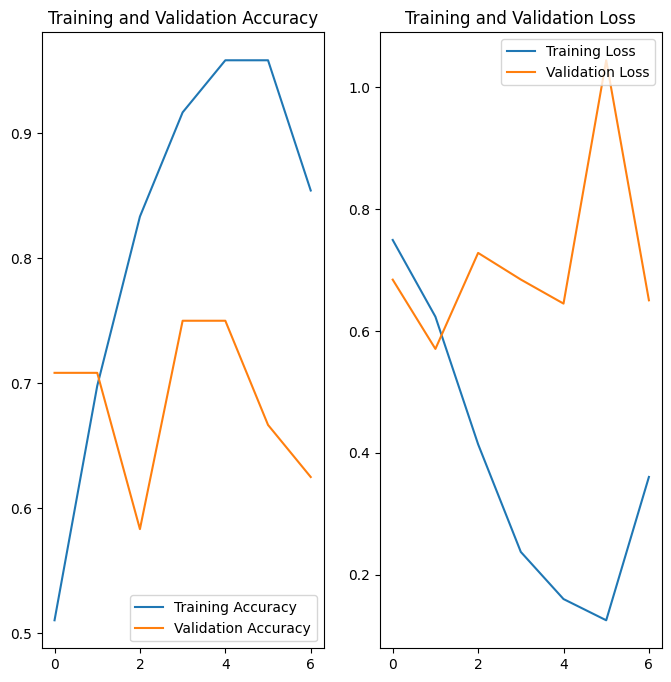

8/8 [==============================] - 0s 9ms/step

Rapport de Classification:
               precision    recall  f1-score   support

Non Manuscrit       0.54      0.58      0.56        12
    Manuscrit       0.55      0.50      0.52        12

     accuracy                           0.54        24
    macro avg       0.54      0.54      0.54        24
 weighted avg       0.54      0.54      0.54        24



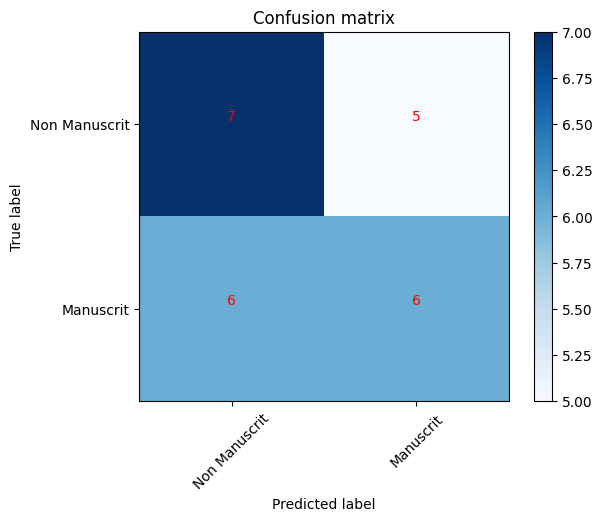

In [6]:
# Dataset path
dataset_path = DATASET_PATH

# Dimensions of images
img_height, img_width = 64, 64

# Model parameters
BATCH_SIZE = 3
EPOCHS = 50

# Create data generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Create model
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# View performances
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

############

# Prédictions sur l'ensemble de test
predictions = model.predict(validation_generator)

# Binariser les prédictions (convertir les probabilités en 0 ou 1)
predicted_labels = np.round(predictions)

# Obtenir les vraies étiquettes de l'ensemble de test
true_labels = validation_generator.classes

# Créer la matrice de confusion
conf_matrix = skm.confusion_matrix(true_labels, predicted_labels)

# Afficher un rapport de classification
class_names = ['Non Manuscrit', 'Manuscrit']
print("\nRapport de Classification:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Afficher la matrice de confusion
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Afficher le nombre d'éléments dans chaque case
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, f"{conf_matrix[i, j]}\n", ha='center', va='center', color='red')

plt.show()